In [52]:
import warnings
import time
import sys
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [53]:
# Initial Values
PLOT_SHOW=True
PLOT_TYPE = False

NUM_TEST = 100
K = 50
NUM_ITERS=10000

STOCKS=['a.us.txt']
labels = ['Close','Open','High','Low']
likelihood_vect = np.empty([0,1])
aic_vect = np.empty([0,1])
bic_vect = np.empty([0,1])

# Possible number of states in Markov Model
STATE_SPACE = range(2,15)

# Calculating Mean Absolute Percentage Error of predictions
def calc_mape(predicted_data, true_data):
    return np.divide(np.sum(np.divide(np.absolute(predicted_data - true_data), true_data), 0), true_data.shape[0])

In [ ]:
#Data Acquisition and finding optimal number of states and prediction
for stock in STOCKS:
    dataset = np.genfromtxt(STOCKS[0], delimiter=',')
    #print(dataset.shape)
    dataset=dataset[1:][:]
    #print(dataset.shape)
    C=dataset[:,4].reshape(dataset.shape[0],1)
    O=dataset[:,1].reshape(dataset.shape[0],1)
    H=dataset[:,2].reshape(dataset.shape[0],1)
    L=dataset[:,3].reshape(dataset.shape[0],1)
    dataset=np.hstack((C,O,H,L))
    dataset=np.flip(dataset,0)
    #print(type(dataset))
    #print(len(dataset),len(dataset[1]))
    #print(dataset[:5,:])

    predicted_stock_data = np.empty([0,dataset.shape[1]])
    likelihood_vect = np.empty([0,1])
    aic_vect = np.empty([0,1])
    bic_vect = np.empty([0,1])
    for states in STATE_SPACE:
        num_params = states**2 + states
        dirichlet_params_states = np.random.randint(1,50,states)
        model = hmm.GaussianHMM(n_components=states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS)
        model.fit(dataset[NUM_TEST:,:])
        if model.monitor_.iter == NUM_ITERS:
            print('Increase number of iterations')
            sys.exit(1)
        likelihood_vect = np.vstack((likelihood_vect, model.score(dataset)))
        aic_vect = np.vstack((aic_vect, -2 * model.score(dataset) + 2 * num_params))
        bic_vect = np.vstack((bic_vect, -2 * model.score(dataset) +  num_params * np.log(dataset.shape[0])))
    
    opt_states = np.argmin(bic_vect) + 2
    print('Optimum number of states are {}'.format(opt_states))
    
    for idx in reversed(range(NUM_TEST)):
        train_dataset = dataset[idx + 1:,:]
        test_data = dataset[idx,:]; 
        num_examples = train_dataset.shape[0]
        #model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', startprob_prior=dirichlet_params, transmat_prior=dirichlet_params, tol=0.0001, n_iter=NUM_ITERS, init_params='mc')
        if idx == NUM_TEST - 1:
            model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS, init_params='stmc')
        else:
            # Retune the model by using the HMM paramters from the previous iterations as the prior
            model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS, init_params='')
            model.transmat_ = transmat_retune_prior 
            model.startprob_ = startprob_retune_prior
            model.means_ = means_retune_prior
            model.covars_ = covars_retune_prior

        model.fit(np.flipud(train_dataset))

        transmat_retune_prior = model.transmat_
        startprob_retune_prior = model.startprob_
        means_retune_prior = model.means_
        covars_retune_prior = model.covars_

        if model.monitor_.iter == NUM_ITERS:
            print('Increase number of iterations')
            sys.exit(1)
        #print('Model score : ', model.score(dataset))
        #print('Dirichlet parameters : ',dirichlet_params)

        iters = 1;
        past_likelihood = []
        curr_likelihood = model.score(np.flipud(train_dataset[0:K - 1, :]))
        while iters < num_examples / K - 1:
            past_likelihood = np.append(past_likelihood, model.score(np.flipud(train_dataset[iters:iters + K - 1, :])))
            iters = iters + 1
        likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
        predicted_change = train_dataset[likelihood_diff_idx,:] - train_dataset[likelihood_diff_idx + 1,:]
        predicted_stock_data = np.vstack((predicted_stock_data, dataset[idx + 1,:] + predicted_change))
    np.savetxt('{}_forecast.csv'.format(stock),predicted_stock_data,delimiter=',',fmt='%.2f')

    mape = calc_mape(predicted_stock_data, np.flipud(dataset[range(100),:]))
    print('MAPE for the stock {} is '.format(stock),mape)

    if PLOT_TYPE:
        hdl_p = plt.plot(range(100), predicted_stock_data);
        plt.title('Predicted stock prices')
        plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
        plt.xlabel('Time steps')
        plt.ylabel('Price')
        plt.figure()
        hdl_a = plt.plot(range(100),np.flipud(dataset[range(100),:]))
        plt.title('Actual stock prices')
        plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
        plt.xlabel('Time steps')
        plt.ylabel('Price')
    else:
        for i in range(4):
            plt.figure()
            plt.plot(range(100), predicted_stock_data[:,i],'k-', label = 'Predicted '+labels[i]+' price');
            plt.plot(range(100),np.flipud(dataset[range(100),i]),'r--', label = 'Actual '+labels[i]+' price')
            plt.xlabel('Time steps')
            plt.ylabel('Price')
            plt.title(labels[i]+' price'+ ' for '+stock[:-4])
            plt.grid(True)
            plt.legend(loc = 'upper left')
        

    if PLOT_SHOW:
        plt.show(block=False)


(4522, 7)
(4521, 7)
<class 'numpy.ndarray'>
4521 4
[[66.81  67.35  67.58  66.7  ]
 [67.47  67.92  67.98  66.91 ]
 [68.11  68.1   68.33  67.771]
 [68.25  68.32  68.64  68.04 ]
 [68.22  68.22  68.45  68.22 ]]
Optimum number of states are 13
MAPE for the stock a.us.txt is  [0.01000733 0.0092592  0.00708666 0.00796134]


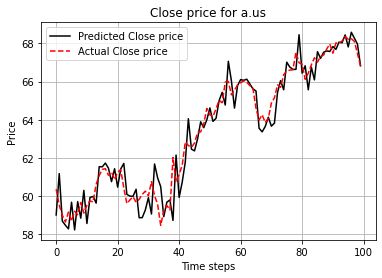

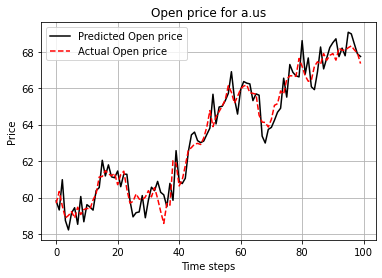

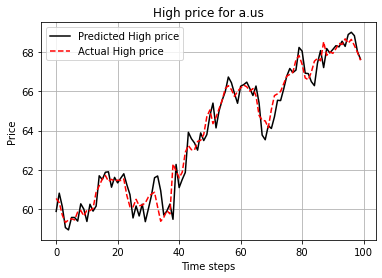

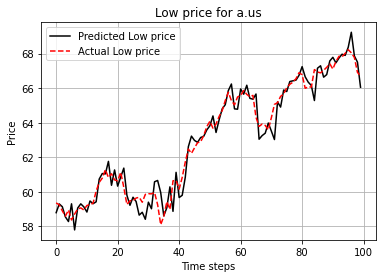

In [2]:
for i in range(5):
    print(i)

0
1
2
3
4
